# **Week 2** 
#### install profer tensorflow version and download imbd_reviews

In [24]:
#!pip install tensorflow==2.1.0 
import tensorflow as tf
print(tf.__version__)


import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2.1.0


#### **Step 1** - read and decode the dataset

In [25]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())
    
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

#### **Step 2** - Use Tokenizer and pad_sequences to transform words in numbers

In [26]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

#### **Step 3** - Reverse the order of word_index (value-key) to facilitate successive steps

In [27]:
reverse_word_index = dict([value,key]  for (key, value) in word_index.items())

def decode_review(text):
    return' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


#### **Step 4** - Create the neural model, with Embeddings, Droput (to improve overfitting), Flattening and the various layers

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 11526     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


#### **Step 5** - fit the model

In [41]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - ETA: 4:20 - loss: 0.6956 - accuracy: 0.46 - ETA: 18s - loss: 0.6934 - accuracy: 0.5137 - ETA: 10s - loss: 0.6922 - accuracy: 0.522 - ETA: 7s - loss: 0.6918 - accuracy: 0.525 - ETA: 5s - loss: 0.6931 - accuracy: 0.51 - ETA: 4s - loss: 0.6922 - accuracy: 0.52 - ETA: 4s - loss: 0.6920 - accuracy: 0.52 - ETA: 3s - loss: 0.6915 - accuracy: 0.52 - ETA: 3s - loss: 0.6907 - accuracy: 0.53 - ETA: 3s - loss: 0.6899 - accuracy: 0.54 - ETA: 3s - loss: 0.6888 - accuracy: 0.54 - ETA: 2s - loss: 0.6869 - accuracy: 0.55 - ETA: 2s - loss: 0.6843 - accuracy: 0.56 - ETA: 2s - loss: 0.6787 - accuracy: 0.58 - ETA: 2s - loss: 0.6719 - accuracy: 0.59 - ETA: 2s - loss: 0.6645 - accuracy: 0.60 - ETA: 2s - loss: 0.6562 - accuracy: 0.61 - ETA: 1s - loss: 0.6470 - accuracy: 0.62 - ETA: 1s - loss: 0.6362 - accuracy: 0.63 - ETA: 1s - loss: 0.6261 - accuracy: 0.64 - ETA: 1s - loss: 0.6172 - accuracy: 0.64 - ET

In [38]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [39]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]


# Sarcasm Dataset - are you sarcastic?

In [124]:
import json

vocab_size = 2000
embedding_dim = 32
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

#import wget
#url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json"
#wget.download(url)

In [72]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [125]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [126]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [127]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [128]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 32)           64000     
_________________________________________________________________
global_average_pooling1d_13  (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 33        
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_________________________________________________________________


In [129]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 2s - loss: 0.6399 - accuracy: 0.6224 - val_loss: 0.5025 - val_accuracy: 0.7870
Epoch 2/30
20000/20000 - 1s - loss: 0.4114 - accuracy: 0.8229 - val_loss: 0.3936 - val_accuracy: 0.8228
Epoch 3/30
20000/20000 - 1s - loss: 0.3515 - accuracy: 0.8469 - val_loss: 0.3881 - val_accuracy: 0.8287
Epoch 4/30
20000/20000 - 1s - loss: 0.3277 - accuracy: 0.8562 - val_loss: 0.3898 - val_accuracy: 0.8281
Epoch 5/30
20000/20000 - 1s - loss: 0.3167 - accuracy: 0.8637 - val_loss: 0.3824 - val_accuracy: 0.8237
Epoch 6/30
20000/20000 - 2s - loss: 0.3075 - accuracy: 0.8657 - val_loss: 0.3772 - val_accuracy: 0.8313
Epoch 7/30
20000/20000 - 1s - loss: 0.3016 - accuracy: 0.8670 - val_loss: 0.3792 - val_accuracy: 0.8310
Epoch 8/30
20000/20000 - 1s - loss: 0.2988 - accuracy: 0.8688 - val_loss: 0.3843 - val_accuracy: 0.8258
Epoch 9/30
20000/20000 - 1s - loss: 0.2956 - accuracy: 0.8699 - val_loss: 0.3861 - val_accuracy: 0.8278
Epoch 10/30
200

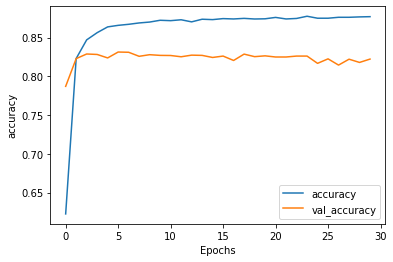

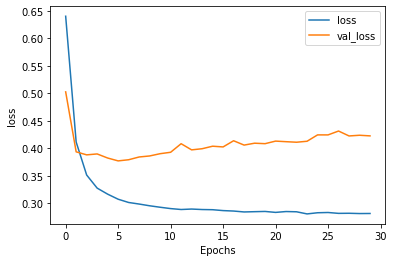

In [130]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [53]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [54]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [56]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[6.217341e-01]
 [1.296852e-05]]


# Imbd_reviews - subwords8k

In [132]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Shuffling and writing examples to C:\Users\Aurel\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteKNQK08\imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\Users\Aurel\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteKNQK08\imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\Users\Aurel\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteKNQK08\imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\Aurel\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [133]:
train_data, test_data = imdb['train'], imdb['test']


In [136]:
tokenizer = info.features['text'].encoder

In [138]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [139]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [140]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [141]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_14  (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [142]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================]0.6934 - accuracy: 0.500 - 1s 307ms/step - loss: 0.6935 - accuracy: 0.468 - 1s 219ms/step - loss: 0.6935 - accuracy: 0.458 - 1s 172ms/step - loss: 0.6935 - accuracy: 0.445 - 1s 144ms/step - loss: 0.6934 - accuracy: 0.450 - 1s 127ms/step - loss: 0.6933 - accuracy: 0.476 - 1s 114ms/step - loss: 0.6933 - accuracy: 0.473 - 1s 103ms/step - loss: 0.6933 - accuracy: 0.468 - 1s 96ms/step - loss: 0.6933 - accuracy: 0.470 - 1s 90ms/step - loss: 0.6933 - accuracy: 0.48 - 1s 84ms/step - loss: 0.6933 - accuracy: 0.48 - 1s 80ms/step - loss: 0.6932 - accuracy: 0.49 - 1s 76ms/step - loss: 0.6932 - accuracy: 0.49 - 1s 73ms/step - loss: 0.6932 - accuracy: 0.50 - 1s 70ms/step - loss: 0.6932 - accuracy: 0.50 - 1s 68ms/step - loss: 0.6932 - accuracy: 0.49 - 1s 66ms/step - loss: 0.6932 - accuracy: 0.49 - 1s 64ms/step - loss: 0.6932 - accuracy: 0.50 - 1s 63ms/step - loss: 0.6932 - accuracy: 0.50 - 1s 61ms/step - loss: 0.6932 - accuracy: 0.50 - 1s 59ms/step -

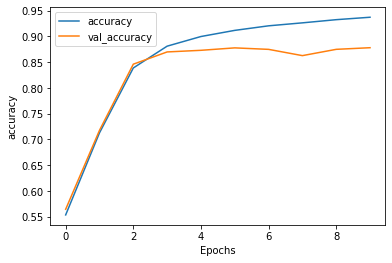

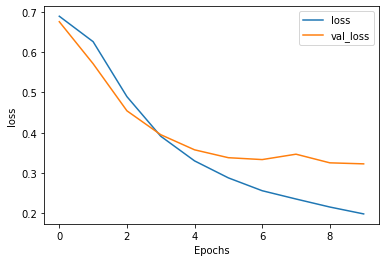

In [144]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [143]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(8185, 64)
